In [1]:
#Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict

import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms

In [2]:
#Data transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

In [3]:
#Data path set

data_dir = f'E:\Projects\\torch\image_data\\flower_data'
train_dir = data_dir + '\\train'
valid_dir = data_dir + '\\valid'
test_dir  = valid_dir

dirs = {'train': train_dir, 
        'valid': valid_dir, 
        'test' : test_dir}

image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'valid', 'test']}

dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes

In [4]:
#Jason file load

with open('cat_to_name.json', 'r') as f:
    label_map = json.load(f)

In [5]:
model = models.densenet161(pretrained=True)
print(model)

C:\ProgramData\Miniconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [6]:
#Custom classifier
classifier = nn.Sequential(OrderedDict([
                                 ('fc1', nn.Linear(2208, 512)),
                                 ('relu', nn.ReLU()),
                                 ('drop_out', nn.Dropout(0.5)),
                                 ('output_fc', nn.Linear(512, 102))
                                 
                                ]))

#turning off gradient in parameters
for param in model.parameters():
    param.requires_grad = False
    
#setting classifier
model.classifier = classifier
model.cuda()


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [7]:
#Function for training the model

def train_model(model, criterion, optimizer, scheduler,    
                num_epochs=10, device='cuda'):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



In [8]:
# Criteria NLLLoss which is recommended with Softmax final layer
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 4 epochs
sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

# Number of epochs
eps=15

In [9]:
#Training model

model_ft = train_model(model, criterion, optimizer, sched, eps, 'cuda')

Epoch 0/14
----------
train Loss: 3.4883 Acc: 0.2431
valid Loss: 1.7624 Acc: 0.6773

Epoch 1/14
----------
train Loss: 1.8399 Acc: 0.5461
valid Loss: 0.8442 Acc: 0.8191

Epoch 2/14
----------
train Loss: 1.3109 Acc: 0.6587
valid Loss: 0.5662 Acc: 0.8851

Epoch 3/14
----------
train Loss: 1.0958 Acc: 0.7118
valid Loss: 0.4346 Acc: 0.9046

Epoch 4/14
----------
train Loss: 0.8956 Acc: 0.7683
valid Loss: 0.3810 Acc: 0.9181

Epoch 5/14
----------
train Loss: 0.8689 Acc: 0.7727
valid Loss: 0.3666 Acc: 0.9279

Epoch 6/14
----------
train Loss: 0.8538 Acc: 0.7740
valid Loss: 0.3473 Acc: 0.9218

Epoch 7/14
----------
train Loss: 0.8323 Acc: 0.7831
valid Loss: 0.3431 Acc: 0.9340

Epoch 8/14
----------
train Loss: 0.8122 Acc: 0.7868
valid Loss: 0.3460 Acc: 0.9291

Epoch 9/14
----------
train Loss: 0.7888 Acc: 0.7941
valid Loss: 0.3377 Acc: 0.9279

Epoch 10/14
----------
train Loss: 0.7932 Acc: 0.7909
valid Loss: 0.3374 Acc: 0.9340

Epoch 11/14
----------
train Loss: 0.7971 Acc: 0.7906
valid Loss

In [10]:
#Model Testing
def calc_accuracy(model, data, cuda=False):
    model.eval()
    model.to(device='cuda')    
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders[data]):

            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()

            # obtain the outputs from the model
            outputs = model.forward(inputs)

            # max provides the (maximum probability, max value)
            _, predicted = outputs.max(dim=1)

            # check the 
            if idx == 0:
                print(predicted) #the predicted class
                print(torch.exp(_)) # the predicted probability
            equals = predicted == labels.data

            if idx == 0:
                print(equals)

            print(equals.float().mean())

In [11]:
#Saving Checkpoint

model_file_name = 'classifier.pth' #file name which will be saved
#Mapping flower names
model.class_to_idx = image_datasets['train'].class_to_idx

#converting model to cpu
model.cpu()

#saving the model
torch.save({'arch': 'densenet161',
            'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx}, 
            model_file_name)

In [12]:
#Load Model Checkpoint
def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)
    
    if chpt['arch'] == 'densenet161':
        model = models.densenet161(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
    
    else:
        print("Sorry base architecture note recognized")
        exit() 
    
    model.class_to_idx = chpt['class_to_idx']
    
    # Create the classifier
    classifier = nn.Sequential(OrderedDict([
                                 ('fc1', nn.Linear(2208, 512)),
                                 ('relu', nn.ReLU()),
                                 ('drop_out', nn.Dropout(0.5)),
                                 ('output_fc', nn.Linear(512, 102))           
                                ]))

    # Put the classifier on the pretrained network
    model.classifier = classifier
    
    model.load_state_dict(chpt['state_dict'])
    
    return model

In [13]:
model = load_model('classifier.pth')
calc_accuracy(model, 'test', True)

tensor([43, 24, 83,  6, 10, 61, 77, 89, 96, 90, 43, 50, 73, 32, 52, 40, 64, 74,
        89, 85, 47, 78, 45, 54, 49, 77, 85, 82, 49, 81,  7, 42],
       device='cuda:0')
tensor([  130.2314,   327.7183,    49.0910,    36.3199,    30.0177,    36.9285,
        13730.6865,   507.6804,     8.8413,    12.7204,   381.6199,     5.6236,
           56.3078,    37.7684,    18.1159,   234.0217,   201.2029,   390.0105,
         1965.5223,     9.1836,   517.6785,  2115.0005,     5.2774,  1689.1813,
            3.5434,   743.1752,    11.2574,  2020.7878,  2357.3877,   104.8961,
            3.7107,    36.2219], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0', dtype=torch.uint8)
tensor(0.8750, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0

In [61]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

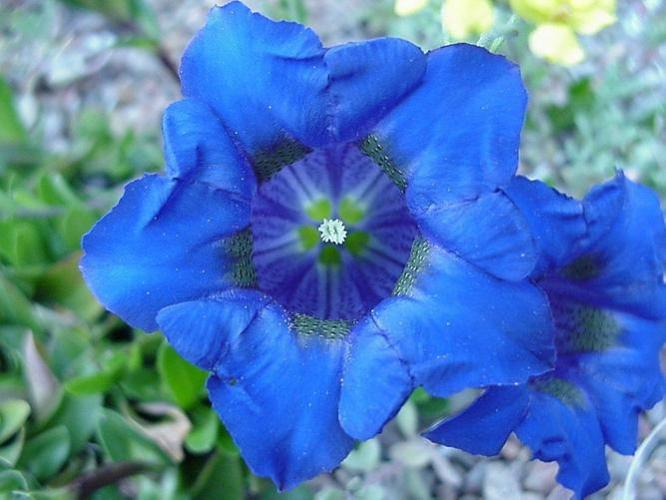

In [16]:
#Process Image
from PIL import Image

image_path = test_dir + '\\28\\image_05258.jpg'
img = Image.open(image_path)

img

In [19]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [20]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    if title:
        plt.title(title)

    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

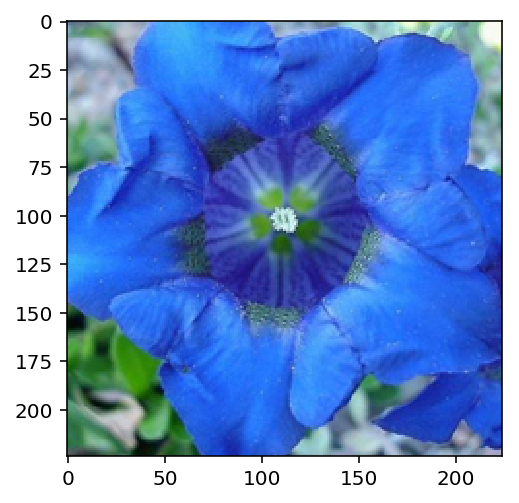

In [21]:
img = process_image(image_path)
imshow(img)

In [22]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)

    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}

    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [label_map[idx_to_class[lab]] for lab in top_labs]

    return top_probs, top_labels, top_flowers

In [59]:
#Sanity Check
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)

    # Set up title
    
    flower_num = image_path.split('E:\\Projects\\torch\\image_data\\flower_data\\valid\\')[1]
    title_ = label_map[flower_num]

    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);

    # Make prediction
    probs, labs, flowers = predict(image_path, model) 

    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

In [66]:
'''
problems:
1. not able to fix #set up title in plot_solution()
2. geting error with ploting even after manually putting the flower number.
    see the last cell
    
3. getting the following error when I am trying to load model in lab

RuntimeError: Error(s) in loading state_dict for DenseNet:
	Missing key(s) in state_dict: "classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias". 
	Unexpected key(s) in state_dict: "features.norm0. ............. many more
'''

print('\n')

61\image_06273.jpg


RuntimeError: Expected object of type torch.FloatTensor but found type torch.cuda.FloatTensor for argument #2 'weight'

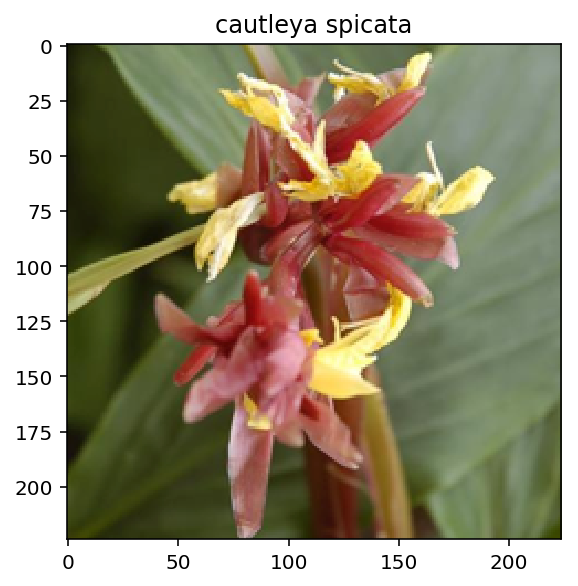

In [60]:
image_path = valid_dir + '\\61\\image_06273.jpg'

plot_solution(image_path, model)